# Ablation Study: Adjustment Types
Here we perform an ablation study demonstrating the (potential) benefit in of the three different adjustment types for PATT (centering, variance adjustments, covariance adjustments) by running six different variants of PATT-GPSS. 
As target distribution we use the multivariate $t$-distribution $\nu = t_{\gamma}(\tau, \Pi)$, with degrees of freedom parameter $\gamma = 10$, location parameter $\tau = \sqrt{d} \cdot (1,...,1)^T \in \mathbb{R}^d$ and scale matrix $\Pi$ constructed by

$$
\Pi = \Pi^{(1)} \Pi^{(2)} \Pi^{(1)} , \\
\Pi^{(1)} = \text{diag}(\sqrt{1},...,\sqrt{d}) , \\
\Pi^{(2)}_{i,j} = \begin{cases} 1 & i = j , \\ 0.5 & i \neq j , \end{cases}
$$

in dimension $d=100$.

In [1]:
from gibbsian_polar_slice_sampling import parallel_gpss
from patt_mcmc import patt_gpss
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path_prefix = "../plots/ablation_study_adj_types_"

### Construct the Target Density

In [4]:
d = 100
df = 10
c = np.full(d, np.sqrt(d))
corr = 0.50
corr_mat = np.full((d,d), corr) + (1 - corr) * np.identity(d)
std = np.sqrt(np.arange(1,d+1))
std_mat = np.diag(std)
scale_mat = std_mat @ corr_mat @ std_mat
inv_scale_mat = alg.inv(scale_mat)
cov = (df / (df-2)) * scale_mat

def log_density(x):
    return -(d+df)/2 * np.log(1 + 1/df * np.inner(x - c, inv_scale_mat @ (x - c)))

### Prepare Storage of Sampler Outputs

In [5]:
snames = ["Plain", "Cen", "Var", "Cov", "Cen+Var", "Cen+Cov"]
nsam = len(snames)
burn_in = []
burn_tde = []
burn_times = []
samples = []
tde = []
times = []
schedules = []
means = []
stds = []
covs = []

In [6]:
def sort_away_ret_dic(ret_dic):
    burn_in.append(ret_dic['burn-in'])
    burn_tde.append(ret_dic['tde_cnts_burn'])
    burn_times.append(ret_dic['runtimes_burn'])
    samples.append(ret_dic['samples'])
    tde.append(ret_dic['tde_cnts'])
    times.append(ret_dic['runtimes'])
    schedules.append(ret_dic['schedule'])
    means.append(ret_dic['means'] if 'means' in ret_dic.keys() else None)
    stds.append(ret_dic['std_devs'] if 'std_devs' in ret_dic.keys() else None)
    covs.append(ret_dic['covs'] if 'covs' in ret_dic.keys() else None)
    del ret_dic

### Run the Samplers

In [7]:
n_chains = 10
n_burn = int(2e4)
n_its = int(1e5)

In [8]:
x_0s = rnd.normal(scale=d, size=(n_chains,d))
w_burn = d**(3/2)
w_att = d

#### Parallel Plain GPSS

In [9]:
full_samples_plain, full_tde_plain, full_times_plain = parallel_gpss(
    log_density,
    n_chains,
    n_burn + n_its,
    x_0s,
    w_burn
)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 120000/120000 [00:58<00:00, 2052.15it/s]


Processing returns and terminating...


In [10]:
burn_in.append(full_samples_plain[:n_burn+1])
burn_tde.append(full_tde_plain[:n_burn+1])
burn_times.append(full_times_plain[:n_burn+1])
samples.append(full_samples_plain[n_burn:])
tde.append(full_tde_plain[n_burn:])
times.append(full_times_plain[n_burn:])
schedules.append(None)
means.append(None)
stds.append(None)
covs.append(None)

#### PATT-GPSS

In [11]:
adj_types = [
    ("mean", None),
    (None, "var"),
    (None, "cov"),
    ("mean", "var"),
    ("mean", "cov"),
]

In [12]:
for cen_mode, cov_mode in adj_types:
    ret_dic = patt_gpss(
        log_density,
        n_chains,
        n_burn,
        n_its,
        x_0s,
        cen_mode=cen_mode,
        cov_mode=cov_mode,
        w_burn=w_burn,
        w_att=w_att
    )
    sort_away_ret_dic(ret_dic)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...
Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...
Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...
Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...
Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


### Analyze Sampling Performance

In [13]:
samples = np.array(samples)[:,n_its//2:] # actively delete the 1st half samples to conserve memory
abs_shifted_samples = np.abs(samples - c)
late_tde = np.array(tde)[:,n_its//2:]
late_times = np.array(times)[:,n_its//2:]
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)

In [14]:
# the IAT computation takes a few minutes
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(late_tde)
total_times = np.array([np.mean(np.sum(ts, axis=0)) for ts in late_times])
sams_per_s = (n_chains * n_its//2) / total_times
maxls = [int(1e4), int(1e4), int(1e4), int(5e3), int(1e3), int(1e3)]
mean_iats = mcu.mean_iat_multi_chain_list(abs_shifted_samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT

In [15]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2) # TDE/MSS = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "TDE/it burn-in",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
    ]
)

,Sampler,TDE/it burn-in,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS
0,Plain,15.87,16.5,21536,679.88,9.27,11218.52,31.68,1.78
1,Cen,15.69,11.7,20433,910.44,29.36,10655.52,22.44,0.4
2,Var,15.73,15.95,16305,509.41,10.32,8127.33,32.01,1.55
3,Cov,15.83,14.82,12993,202.59,13.31,3002.9,64.14,1.11
4,Cen+Var,15.99,9.98,22912,191.18,48.66,1908.14,119.85,0.21
5,Cen+Cov,15.9,7.06,24866,2.91,93.13,20.53,8555.48,0.08


**Note:** If the *TDE/it burn-in* values vary significantly across different samplers, that is a sign that either the initialization or the randomness led at least some chains of some samplers very far into the tails during burn-in. This may be viewed as reducing the comparability between the samplers in the present run, given that they are supposed to all work exactly equally well in the burn-in phase.

### Plotting

In [16]:
default_cycler = plt.rcParams["axes.prop_cycle"]
colors = plt.cm.viridis(np.linspace(0, 0.9, nsam-1))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", colors)

In [17]:
figsize = (10,10)
dpi = 200
n_win = int(1e4)
nsamples = n_chains * n_its // 2
bins = nsamples // 1000
maxstep = np.quantile(flat_steps, 0.995)

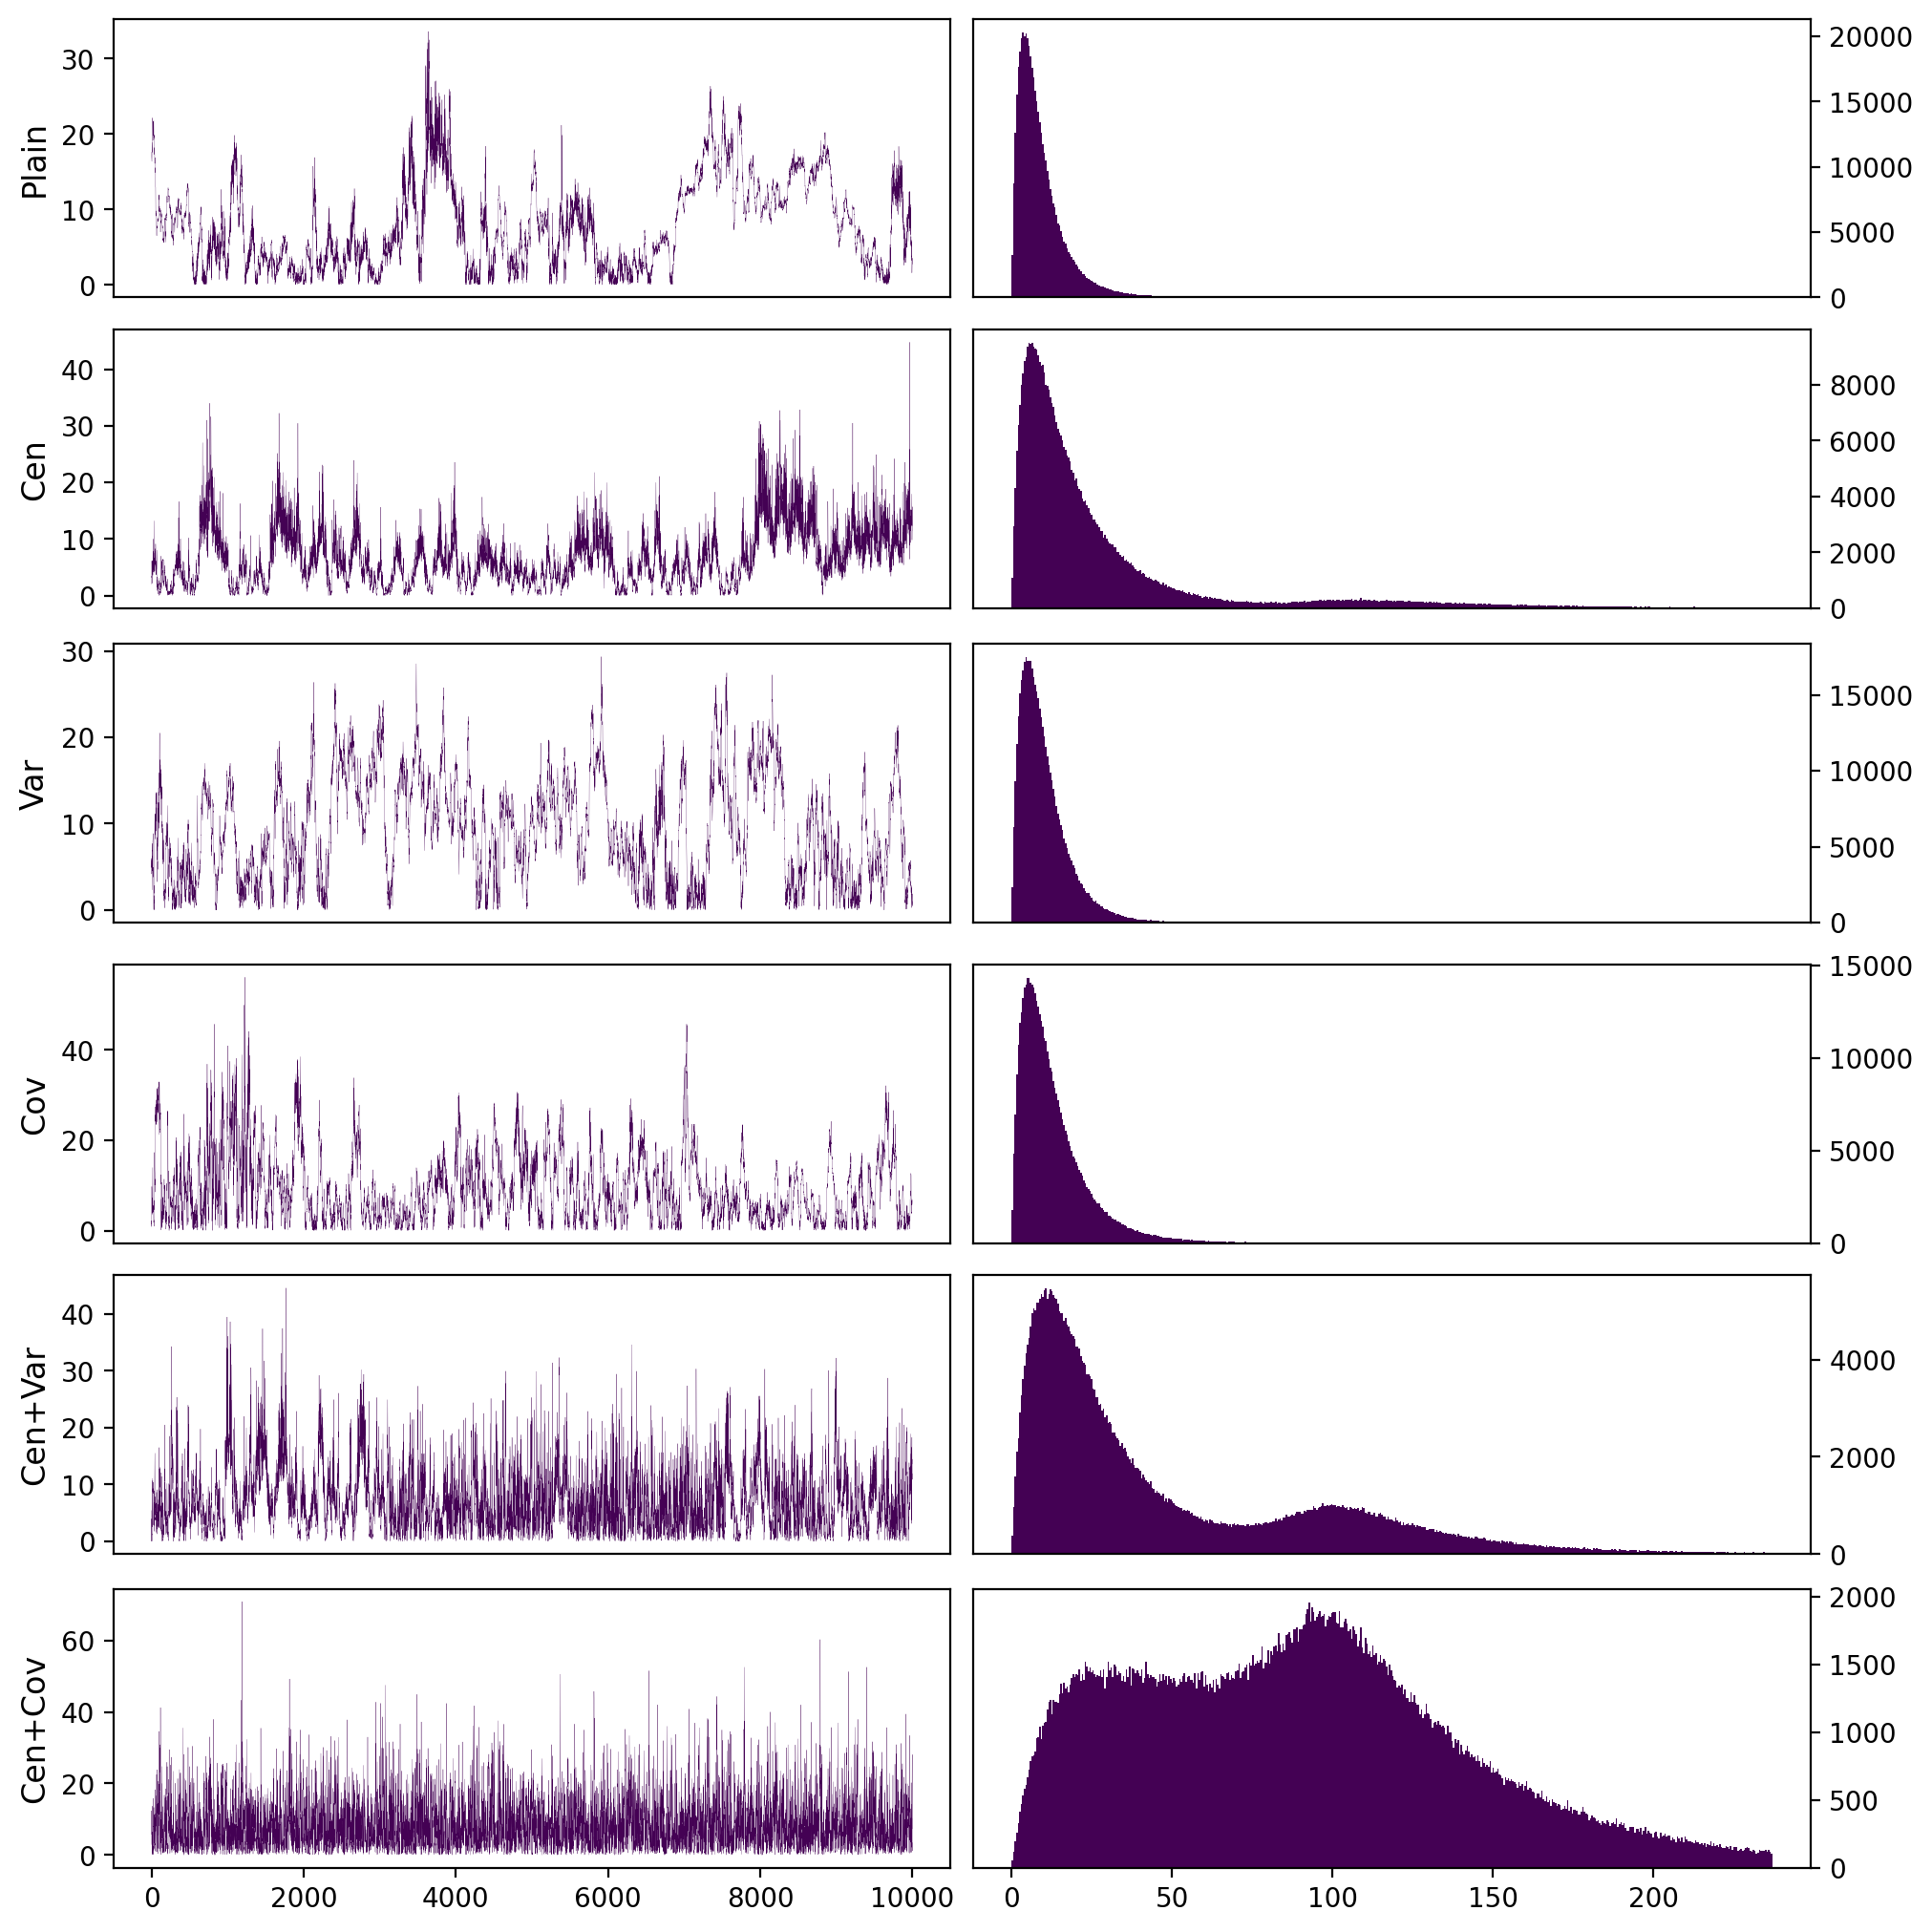

In [18]:
plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
for i in range(nsam):
    # 1st column: trace of a sample summary
    ax = plt.subplot(nsam, 2, 2*i + 1)
    ax.plot(abs_shifted_samples[i,-n_win:,0,-1], linewidth=0.1)
    ax.set_ylabel(snames[i], fontsize=12)
    if i + 1 < nsam:
        ax.set_xticks([])
    # 2nd column: step size histogram
    ax = plt.subplot(nsam, 2, 2*i + 2)
    ax.hist(flat_steps[i], bins=bins, range=(0,maxstep))
    if i + 1 < nsam:
        ax.set_xticks([])
    ax.yaxis.tick_right()
plt.savefig(path_prefix + "overview.png")
plt.show()

In [19]:
split = nsam // 2

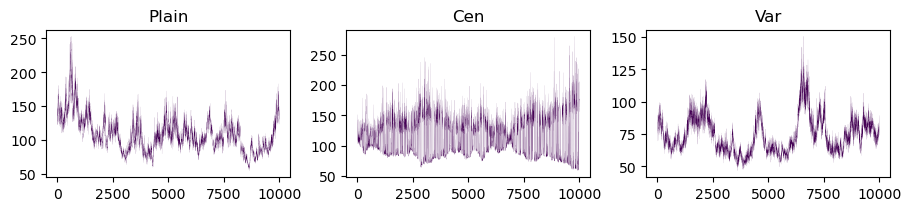

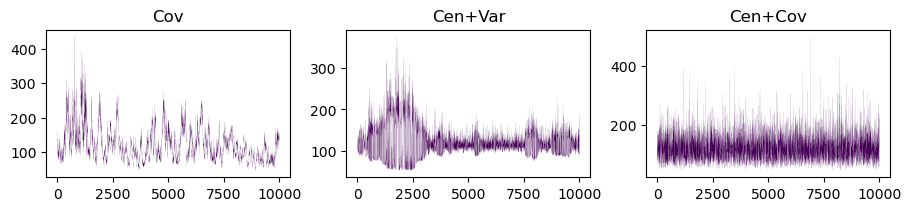

In [20]:
lw = 0.05
plot_rs = [rs[-n_win:,0] for rs in radii]
pfs.trace_plot_row(plot_rs[:split], snames[:split], lws=lw)
pfs.trace_plot_row(plot_rs[split:], snames[split:], lws=lw)

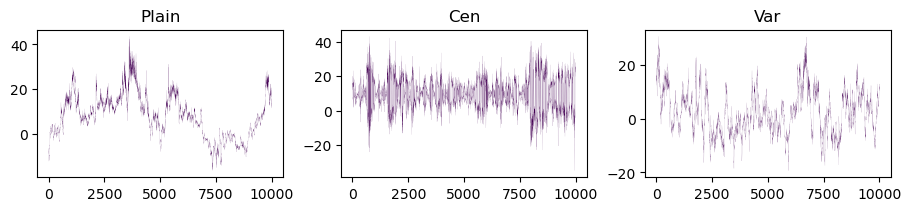

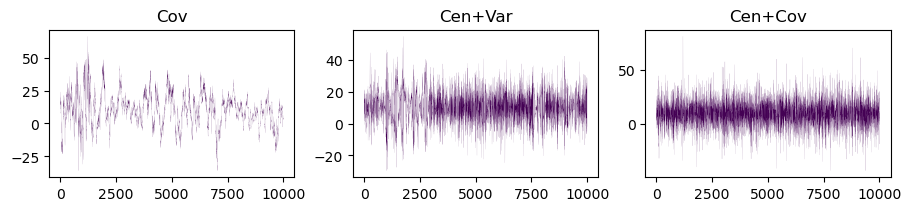

In [21]:
plot_msams = [sams[-n_win:,0,-1] for sams in samples]
pfs.trace_plot_row(plot_msams[:split], snames[:split], lws=lw)
pfs.trace_plot_row(plot_msams[split:], snames[split:], lws=lw)

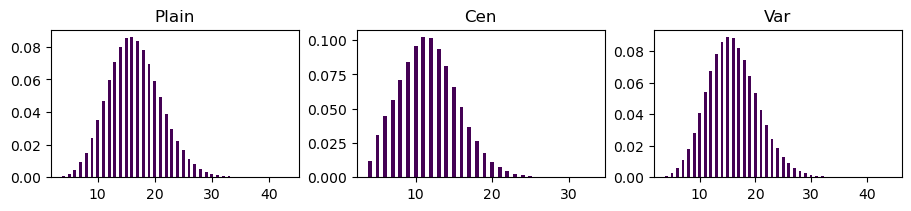

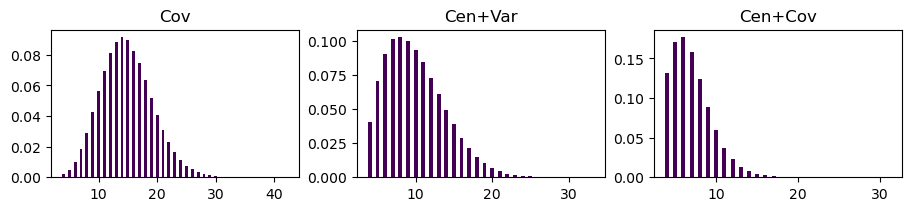

In [22]:
pfs.plot_tde_distr_row(late_tde[:split], snames[:split])
pfs.plot_tde_distr_row(late_tde[split:], snames[split:])

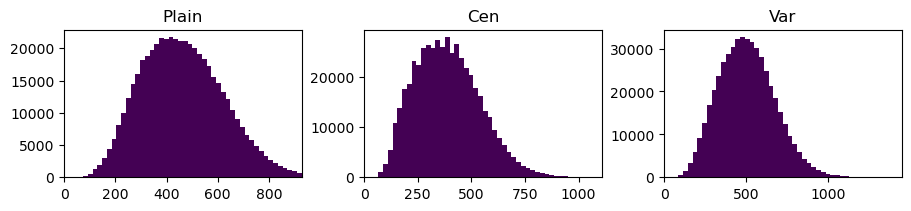

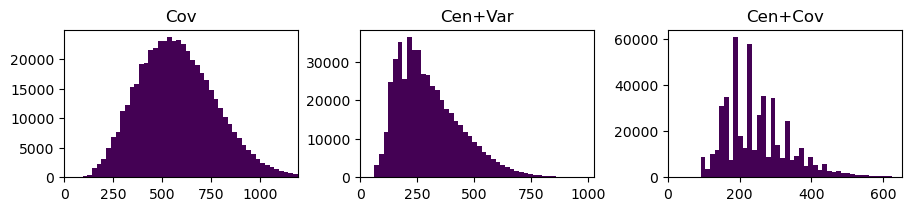

In [23]:
pfs.plot_runtime_hist_row(late_times[:split], snames[:split], cutoff_quant=0.995)
pfs.plot_runtime_hist_row(late_times[split:], snames[split:], cutoff_quant=0.995)

In [24]:
figsize = (3,2)
dpi = 100

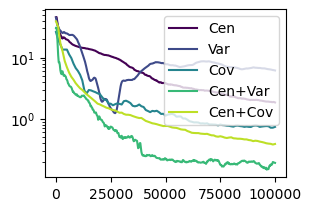

In [25]:
has_means = [type(mns) != type(None) for mns in means]
mean_devs = [(alg.norm(means[i] - c, axis=1) if has_means[i] else None) for i in range(nsam)]
pfs.initiate(figsize, dpi)
plt.yscale("log")
for i in range(nsam):
    if has_means[i]:
        plt.plot(schedules[i], mean_devs[i])
plt.legend([snames[i] for i in range(nsam) if has_means[i]])
pfs.wrapup()

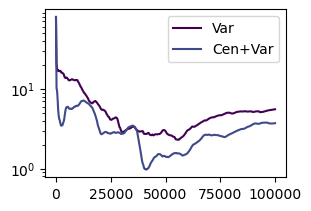

In [26]:
has_stds = [type(stds_) != type(None) for stds_ in stds]
std_devs = [(alg.norm(stds[i] - np.sqrt(df / (df - 2)) * std, axis=1) if has_stds[i] else None) for i in range(nsam)]
pfs.initiate(figsize, dpi)
plt.yscale("log")
for i in range(nsam):
    if has_stds[i]:
        plt.plot(schedules[i], std_devs[i])
plt.legend([snames[i] for i in range(nsam) if has_stds[i]])
pfs.wrapup()

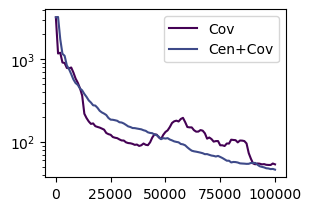

In [27]:
has_covs = [type(covs_) != type(None) for covs_ in covs]
cov_devs = [(alg.norm(covs[i] - cov, axis=(1,2))) if has_covs[i] else None for i in range(nsam)]
pfs.initiate(figsize, dpi)
plt.yscale("log")
for i in range(nsam):
    if has_covs[i]:
        plt.plot(schedules[i], cov_devs[i])
plt.legend([snames[i] for i in range(nsam) if has_covs[i]])
pfs.wrapup()

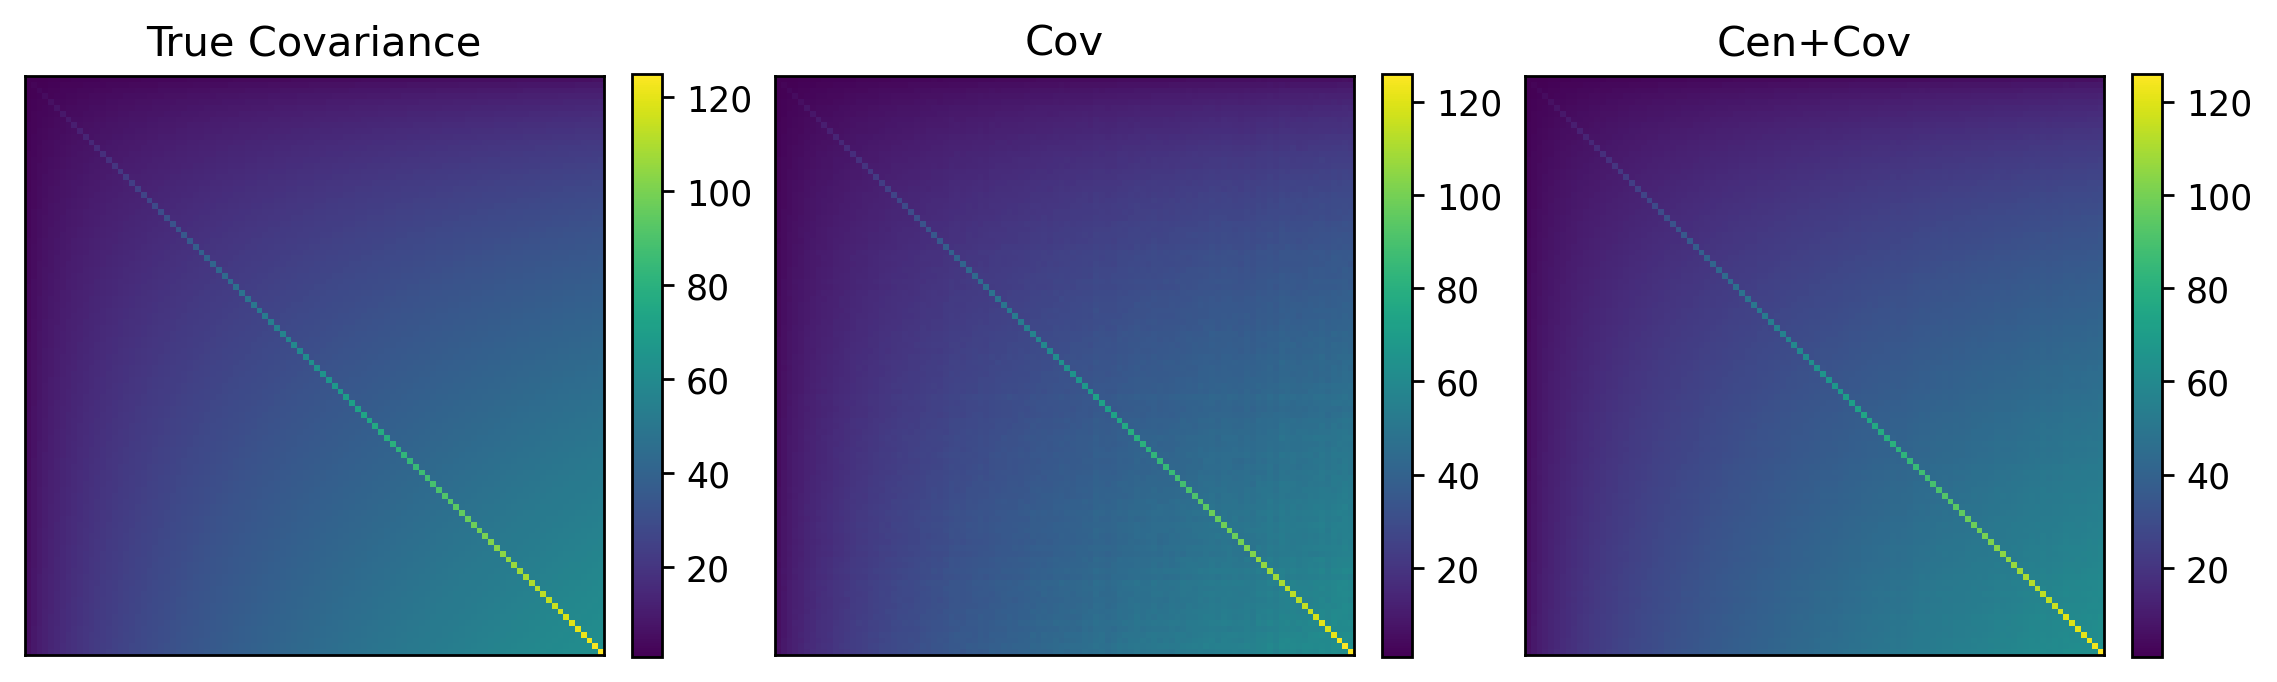

In [28]:
covs_plot = [cov] + [covs[i][-1] for i in range(nsam) if has_covs[i]]
snames_plot = ["True Covariance"] + [snames[i] for i in range(nsam) if has_covs[i]]
pfs.plot_covs_row(covs_plot, snames_plot, shrink=0.8)

In [29]:
plt.rcParams["axes.prop_cycle"] = default_cycler